# Intro
This is an exercise to understand and explore word vectors using Python, Gensim, and pre-trained GloVe word embeddings.

The activities described in this notebook are part of Stanford's CS224N. You can read the accompanying article [here](https://ivanperez.pe/).

# 1. Preliminars


## 1.1. Dependencies

In [ ]:
import pprint
import random
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters')  # This downloads a zipped file, -o forces overwrite
!unzip -o /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora/
from nltk.corpus import reuters

from sklearn.decomposition import PCA  # Needed for dimensionality reduction
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.decomposition import TruncatedSVD  # Dimensionality reduction

## 1.2. Global Variables and Initializations

In [2]:
START_TOKEN = "<START>"
END_TOKEN = "<END>"

np.random.seed(0)
random.seed(0)

# 2. Word Vectors

We will be using the Reuters (business and financial news) corpus. The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test samples. For more information on this corpus refer to the NLTK book.

## 2.1. Part 1: Count-based Word Vectors

### Load the corpus

In [3]:
def read_corpus(category:str ="crude") -> list:
  """ Read files from the specified Reuter's category.
    Params:
    ------
        category (string): category name
    Return:
    ------
        list of lists, with words from each of the processed files
  """

  files = reuters.fileids(category)

  return [
          [START_TOKEN] +
          [w.lower() for w in list(reuters.words(f))] +
          [END_TOKEN]
          for f in files
  ]

Let's have a look what these documents are like….

In [ ]:
# If a category is missing, just delete it from the cats.txt file
reuters_corpus = read_corpus()
print(f"Len. of corpus is: {len(reuters_corpus)}")
pprint.pprint(reuters_corpus[:1], compact=True, width=100)

Len. of corpus is: 578
[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revise

### Create the vocabulary

In [4]:
def distinct_words(corpus: list) -> tuple:
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    corpus_words = list(set([word for doc in corpus for word in doc]))

    num_corpus_words = len(corpus_words)
    # ------------------

    return sorted(corpus_words), num_corpus_words

Sanity check:

In [5]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

print(f"Corpus is: {test_corpus} with length = {len(test_corpus)}")
print(f"Vocabulary is: {test_corpus_words} with length = {len(test_corpus_words)}")

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Corpus is: [['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'], ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']] with length = 2
Vocabulary is: ['<END>', '<START>', 'All', "All's", 'ends', 'glitters', 'gold', "isn't", 'that', 'well'] with length = 10
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Compute the co-occurrence matrix

In [8]:
def compute_co_occurrence_matrix(corpus: list, window_size:int =4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents like: [
                ['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'],
                ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']
              ]
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    
    # Get the vocabulary which is like ['<END>','<START>','All',"All's",
    # 'ends','glitters','gold',"isn't",'that','well']
    words, num_words = distinct_words(corpus)

    M = None
    word2ind = {}
    
    # -------------------------------------------------------------------------
    
    def _get_vicinity(w_i: str, corpus: list, window_size: int=4) -> list:
      """
      Returns a list with words located after or before of current word w_ij
      given a window_size. For example, if the corpus is
      [
        ['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'],
        ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']
      ]
      the vicinity/CONTEXT of "well" is: ["All's", 'that', 'ends', '<END>']

      Parameters
      ----------
      - w_i (str): The target word for which we'll determine its vicinity
      - corpus (list): A list of lists, each item represent a document
      - window_size (int): The range where we'll find neighbor words for w_i

      Returns
      -------
      A list of words which are neighbors of w_i given a window_size
      """
      
      neighbors = []

      for doc in corpus:
        if w_i in doc:  # The word can appear several time in the document!
          
          # Indices where w_i appears in the current document
          indices = [idx for idx, value in enumerate(doc) if value == w_i]

          for i in indices:
            lower_bound = i - window_size if i > window_size else 0
            upper_bound = i + 1 + window_size  # No error if x[i: out-of-bounds]

            neighbors.append(doc[lower_bound: i])
            neighbors.append(doc[i + 1: upper_bound])

      return [neighbor[0] for neighbor in neighbors if len(neighbor) > 0]

    # .........................................................................

    # Initialize the Matrix
    M = np.zeros((num_words, num_words))

    # word2ind is like: {0: '<END>', 1: '<START>', 2: 'All', ... }
    word2ind = {word:idx for idx, word in enumerate(words)}

    # For each word w_i in the vocabulary:
    #   Given w_i, how often the word w_ij co-occurs in the vicinity of w_i
    #   with current window_size? j = 1 ... len(vocabulary)
    for w_i in words:
      i = word2ind[w_i]  # Get the index of the current word w_i
      w_ij = _get_vicinity(w_i, corpus, window_size)

      for j, word_j in enumerate(words):
        if word_j in w_ij:
          M[i, j] += 1 
    # -------------------------------------------------------------------------

    return M, word2ind

Sanity check:

In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Reduce the co-occurrence matrix dimensionality with SVD

In [10]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

**Note**: TruncatedSVD returns U*S, then we need to normalize (rescale) the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). We achieve this normalization through the NumPy concept of broadcasting.

Sanity check:

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Enable the word embeddings plotter

In [12]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # M_reduced contains the values to plot
    labels = words
    x_values = M_reduced[:, 0]  # 1st column of words embeddings (1st dimension)
    y_values = M_reduced[:, 1]  # 2nd column of word vectors (2nd dimension)

    for idx, label in enumerate(labels):
      x = x_values[idx]
      y = y_values[idx]

      plt.scatter(x, y, marker="x", color="red")
      plt.text(x + 0.01, y, label, fontsize=9)
    # ------------------



Sanity check:

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


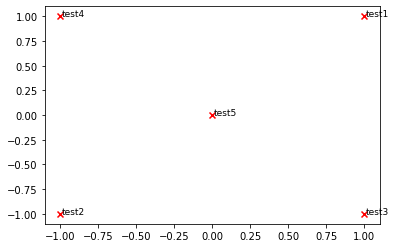

In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Co-occurence plot analysis for Reuter's "crude" corpus

In [14]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting


Running Truncated SVD over 8185 words...
Done.


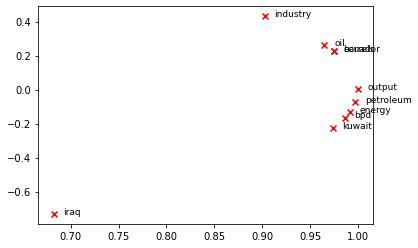

In [15]:
# Plot a set of words using the trained embedding model
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

We can see a clear cluster of words that includes `output`, `petroleum`, `energy`, `bdp`, and `kuwait`, if we expand this cluster a little bit we can even include `oil`, `ecuador`, and `barrels`. Oddly, `iraq` appears way too far from the main cluster. This makes me think this count-based method is not accurate enough.

## 2.2. Part 2: Prediction-Based Word Vectors

### Downloading and loading pre-trained GloVe word vectors
Loaded vocab size 400K 🤩 stored in `wv_from_bin` variable

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


### Reducing dimensionality of GloVe Word Embeddings

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

**Note**: To avoid running out of memory, we will work with a sample of 10K:

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### GloVe plot analysis for Reuter's "crude" corpus

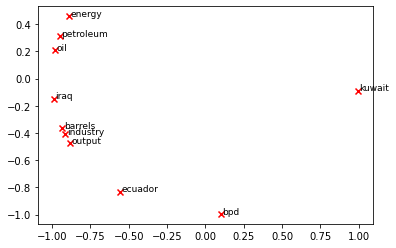

In [ ]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

GloVe seems to produce better results, now it seems we have the main cluster containing most of the words in the sample set. Nevertheless, it is still odd `kuwait` is far apart from words like `oil`. Why is this happening? Perhaps it is because we are using a small sample of 10K GloVe vectors, or it may also be related to truncation when doing the dimensionality reduction. Another possibility is that in the selected 10K GloVe vectors `kuwait` doesn't appear with enough frequency in the context of the other words.

### Quantifying the similarity between individual words vectors
We can use the pre-trained GloVe word vectors loaded through gensim before (`glove-wiki-gigaword-200`) to find polysemes. The `most_similar` method is available from the model/dataset returned by `api.load("glove-wiki-gigaword-200")` and uses the concept of cosine similarity to return the top-10 most similar words for a given parameter.

In [ ]:
# Next is based on the `glove-wiki-gigaword-200` GloVe vectors that contains 400K word embeddings
wv_from_bin.most_similar("branch")

[('branches', 0.7101372480392456),
 ('central', 0.5476117730140686),
 ('railway', 0.5329204797744751),
 ('established', 0.5197478532791138),
 ('line', 0.5076225399971008),
 ('authority', 0.491929292678833),
 ('offices', 0.48285460472106934),
 ('railroad', 0.4816432297229767),
 ('headquarters', 0.4756273925304413),
 ('department', 0.4709719121456146)]

We can find polysemes like `plant` (`factory` / `flowering`) or `break` (`broke` / `time`). Nevertheless, there were no good results for words like `branch` which didn't return tree-related words. Why is that? Probably because of the dataset used during the training process that returned the loaded word vectors. It might happen that the dataset didn't have a varied enough context for these words.

### What about Synonyms and Antonyms?
We can use the concept of cosine distance to confirm the similarity of two words (synonyms), but the cosine distance reveals something odd. There are cases where the opposite word is closer than a synonym word, for example: 

In [ ]:
# wv_from_bin.most_similar("top")

# w1 = top w2 = pinnacle/summit/peak/apex, w3 = bottom
# w1 and w2 can be considered synonyms
# w1 and w3 can be considered antonyms

# Distance among synonyms are 0.76/0.67/0.67/0.79
# wv_from_bin.distance("top", "apex")

# Distance among antonyms is 0.49
wv_from_bin.distance("top", "bottom")

0.4903566241264343

Why is this happening? I guess it is because of the data used to train the model. Probably the training examples contain contexts for `top` related to success, leadership, and businesses which probably are not so rich in vocabulary.

### Finding analogies
The `most_similar` method from gensim allow extra parameters that can be used to find analogies. For example, `man:king :: woman:?` can be solved like this:
```python
result = wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man'])
```
This will output a list of possible answers with a given similarity value. `Queen` is the top word. 
As professor Manning showed in class, it is useful to turn the above instruction to a function like this:

In [ ]:
def analogy(x1, x2, y1):
    result = wv_from_bin.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

analogy("man", "king", "woman")

'queen'

Gensim documentation states that the `positive` parameter contains keys that contribute positively towards the similarity and the opposite for the `negative` parameter.
This is interesting because it kind of defines what an analogy is, in this case, we ask the model: give me words that are similar to `king` and `woman` but different than `man`. This is why we get a top-10 list of possible values when running `most_similar`:

```python
[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]
```

Playing with the `analogy` function we can have results like:

In [ ]:
analogy("legs", "pants", "chest")

'jacket'

In [ ]:
analogy("peru", "peruvian", "chile")

'chilean'

Sadly, not all analogies hold according to the pre-trained GloVe vectors. This is the case of `hand:glove :: foot:?` where we get:

In [ ]:
analogy("hand", "glove", "foot")

'45,000-square'


I wonder if we'll get better results with a Word2Vec pre-trained model instead.

## 2.3. Bias in Word Vectors

Word embeddings are susceptible to bias. This is dangerous because it can reinforce stereotypes through applications that employ these models. For example, in the code snippet below we are asking the model for words similar to "woman" and "worker" but different to "man".

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


We can clearly see gender bias when `nurse` and `teacher` are close to `woman` but so far from `man` that they do not appear in the top 10 list of similar words. Also, we can see that `mechanic` is close to `man` but far from `woman`. Why is this happening? again because of the data used to train the models. Sadly the trained data is a reflection of our society.

This is sad, and is present in other examples that reflect how our societies generalize over different topics:

In [ ]:
pprint.pprint(wv_from_bin.most_similar(positive=['latin', 'criminal'], negative=['white']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['white', 'criminal'], negative=['latin']))

[('trafficking', 0.4996181130409241),
 ('transnational', 0.44992437958717346),
 ('crimes', 0.43998926877975464),
 ('laundering', 0.4213477373123169),
 ('crime', 0.42046865820884705),
 ('cartels', 0.417102575302124),
 ('dealing', 0.4154001474380493),
 ('traffickers', 0.40704718232154846),
 ('judicial', 0.39766523241996765),
 ('extradition', 0.3974517583847046)]

[('prosecution', 0.5594319105148315),
 ('crimes', 0.5117124915122986),
 ('fbi', 0.5068686008453369),
 ('attorney', 0.5007576942443848),
 ('investigation', 0.49686378240585327),
 ('charges', 0.49135079979896545),
 ('charged', 0.48554402589797974),
 ('prosecutors', 0.4846910238265991),
 ('attorneys', 0.47757965326309204),
 ('suit', 0.476983904838562)]


How can we avoid this bias? Not sure, the only thing I can think of is taking random samples of the data before training. Then examining these samples trying to find common biases in topics like gender, ethnicity, sexual orientation, etc.